# XFEL.EU HDF5 Format Example #

Below is a set of probably minimal imports to work with HDF5 data in Python:

- numpy is used for numerical operations
- matplotlib is used for plotting, we enable it to display inline with the `%matplitlib inline` magic
- h5py will be used to open HDF5 files in python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

/s/ls4/users/sbobkov/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Opening a HDF5 file using `h5py` is straight forward via `h5py.File`. Be sure to set `"r"` as an option to open in read-only mode. Otherwise you might unintentionally alter the data in the file you are working with.

In [2]:
f = h5py.File("./example_data/R0126-AGG01-S00002.h5", "r")

This is the top-level structure of an XFEL-DAQ formatted HDF5 file. Interesting for data analysis are entries in the `CONTROL`, `INSTRUMENT`, `INDEX` and `RUN` groups:

- `CONTROL` contains all selected data sources which are considered "slow" data. They are correlated on the 10Hz train frequency and published by the message broker system in Karabo
- `INSTRUMENT` contains all selected data sources that are published by bypassing the broker. This is usually camera data at 10Hz, digitizer data, or data from the MHz detectors. This data can have train or pulse resultion.
- `INDEX` contains global indexing information, such as the train ids valid for all datasets 
  in the file.
- `RUN` contains a snapshort of all selected data sources at the beginning of the run context a file was recorded with

In [3]:
for k in f.keys():
    print(k)  

CONTROL
INDEX
INSTRUMENT
METADATA
RUN


In `h5py` we can access datasets as if we where indexing a python dictionary. The `CONTROL` data sections thus looks like this:

In [4]:
def rec_print_h5_level(ds, indent=0, maxlen=2):
    for k in list(ds.keys())[:maxlen]:
        print(" "*indent+k)
        if isinstance(ds[k], h5py.Group):
            rec_print_h5_level(ds[k], indent+4, maxlen)

rec_print_h5_level(f["CONTROL"])

DETLAB_LAB_LPD1M-1
    FPGA
        FEM_Q4M1
            sensor10Voltage
                value
                timestamp
            powerCardOverTemp1
                value
                timestamp
        FEM_Q4M3
            sensor10Voltage
                value
                timestamp
            powerCardOverTemp1
                value
                timestamp


The different hiearchy levels identify data sources by there Karabo instance name. Here we have two FPGAs of the LPD frontend electronics as slow data producers: `DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1` and `DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3`. Control data sources are thus defined on a Karabo device level. Below the device instance name the device properties are recorded.

Each of these properties contains two data sets:

- `value` contains the property value as recorded for a given train
- `timestamp` contains a Karabo timestamp the property was recorded at

Both these data sets are one-dimensional arrays of the same length. 

In [5]:
def print_value_and_timestamp_length(path):
    value_key = "{}/value".format(path)
    tstamp_key = "{}/timestamp".format(path)
    print("Length of data set at {}: {}".format(path, len(f[value_key])))
    print("Length of timestamp at {}: {}".format(path, len(f[tstamp_key])))

for i in range(0, 4):
    key = "sensor{}Current".format(i)
    h5key = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/{}".format(key)
    print_value_and_timestamp_length(h5key)

Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor0Current: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor0Current: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor1Current: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor1Current: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor2Current: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor2Current: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor3Current: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/sensor3Current: 10


In fact all properties of all data sources in the `CONTROL` section are of the same length. There is thus a 1-to-1 mapping between all indices in the `CONTROL` section: a given index in any of the arrays will always identify the same train and thus same point in time:

In [6]:
for i in range(0, 4):
    key = "sensor{}Voltage".format(i)
    h5key = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/{}".format(key)
    print_value_and_timestamp_length(h5key)
    
print("Length of train Ids: {}".format(len(f["INDEX/trainId"])))

Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor0Voltage: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor0Voltage: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor1Voltage: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor1Voltage: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor2Voltage: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor2Voltage: 10
Length of data set at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor3Voltage: 10
Length of timestamp at CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/sensor3Voltage: 10
Length of train Ids: 10


This allows us to easily correlate all values with each other. Note however, that the timestamp does not change for the plotted values. This is because the device recording the temperature we plot polls at an interval of ~1 second. The timestamp is thus not expected to change in the ten trains we plot.

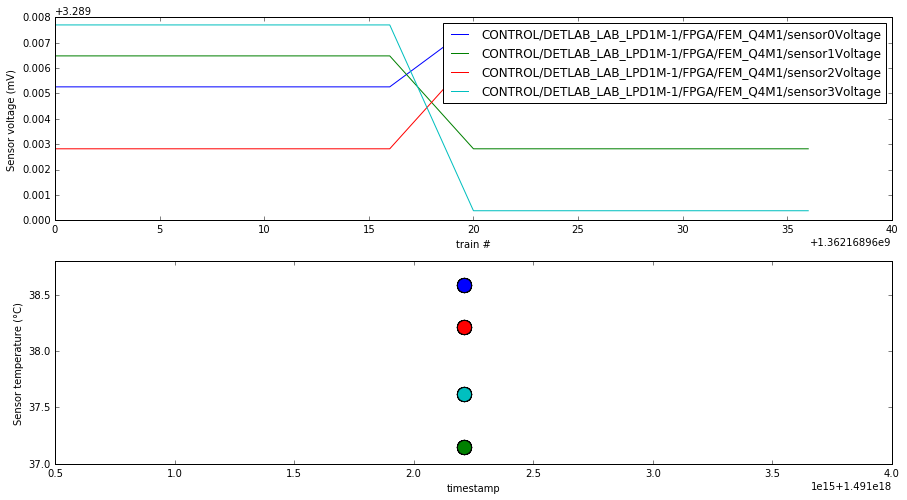

In [7]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for i in range(4):
    key = "sensor{}Voltage".format(i)
    path = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/{}".format(key)
    value_key = "{}/value".format(path)
    lp = ax1.plot(f["INDEX/trainId"], f[value_key], label=path)
    
    key = "sensor{}Temp".format(i)
    path = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/{}".format(key)
    value_key2 = "{}/timestamp".format(path)
    
    key = "sensor{}Temp".format(i)
    path = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M3/{}".format(key)
    value_key3 = "{}/value".format(path)
    
    ax2.scatter(f[value_key2], f[value_key3], s=200, c=lp[0].get_color())
    
leg = ax1.legend()
xlbl = ax1.set_xlabel("train #")
ylbl = ax1.set_ylabel("Sensor voltage (mV)")

xlbl = ax2.set_xlabel("timestamp")
ylbl = ax2.set_ylabel("Sensor temperature (°C)")

`INSTRUMENT` data on the other hand can be pulse resolved. It thus contains additional indices, as here exemplarily shown for one of the fast detectors:

In [8]:
rec_print_h5_level(f["INSTRUMENT"], maxlen=10)

DETLAB_LAB_DAQ-0
    DET
        0:xtdf
            header
                magicNumberBegin
                majorTrainFormatVersion
                minorTrainFormatVersion
                trainId
                linkId
                pulseCount
                dataId
                reserved
            detector
                data
                trainId
            trainBuilder
                data
                trainId
            image
                pulseId
                status
                length
                cellId
                trainId
                data
            trailer
                checksum
                magicNumberEnd
                status
                trainId


The image data can be found underneath the `image` key (relevant fields only):

- `data` is the image data, of dimensions `images`x`modules`x`pixels`x`pixels`.
- `pulseId` is an array identifying the pulse id each image was recorded at. Its indices match those of the first `data` dimension.
- `status` is an array identifying detector error conditions in a bit field. Its values are 0 if everything is okay. Its indices match those of the first `data` dimension.
- `cellId` is an array identifying the detector memory cell each image was recorded too. Its indices match those of the first `data` dimension.
- `trainId` is an array identifying the train id each image was recorded at. Its indices match those of the first `data` dimension.

In [9]:
print(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/data"].shape)
print(len(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/pulseId"]))
print(len(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/status"]))
print(len(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/trainId"]))
print(len(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/cellId"]))


(5040, 1, 256, 256)
5040
5040
5040
5040


Correlating fast data amongst each other is thus straight forward again, as the indices will always match up:

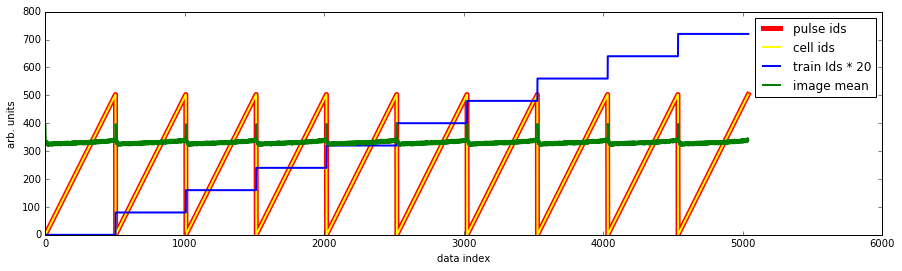

In [10]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
cells = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/cellId"]
pulses = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/pulseId"]
trains = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/trainId"]
data = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/data"]

lp = ax.plot(pulses, c="red", lw=5, label="pulse ids")
lp = ax.plot(cells, c="yellow", lw=2, label="cell ids")
lp = ax.plot((trains-np.min(trains))*20, lw=2, label="train Ids * 20")
lp = ax.plot(np.mean(data, axis=(1,2,3))-800, lw=2, label="image mean")
lgd = ax.legend()
xlbl = ax.set_xlabel("data index")
ylbl = ax.set_ylabel("arb. units")

Finally, to correlate slow and fast data, we can either index independently, or e.g. super-sample the slow data to match the indices of the fast data. Below we chose this latter approach, using a combination of `np.histogram` to count the occurances of the same train for variable pulse lengths (not strictly needed in this example), and `np.repeat` to super-sample the slow `CONTROL` data.

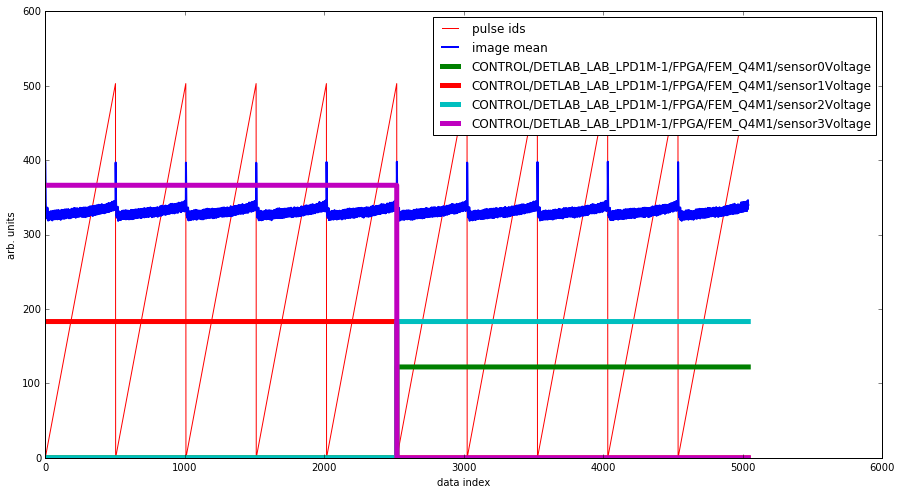

In [11]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

pulses = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/pulseId"]
trains = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/trainId"]
data = f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/data"]

lp = ax.plot(pulses, c="red", lw=1, label="pulse ids")
lp = ax.plot(np.mean(data, axis=(1,2,3))-800, lw=2, label="image mean")

# using histogram we get the number of occurances of 
# actually present trains
train_range = np.max(f["INDEX/trainId"])-np.min(f["INDEX/trainId"])
train_occurances, _ = np.histogram(trains, bins=train_range)
train_occurances = train_occurances[train_occurances != 0]

slow_trains = f["INDEX/trainId"]
for i in range(4):
    key = "sensor{}Voltage".format(i)
    path = "CONTROL/DETLAB_LAB_LPD1M-1/FPGA/FEM_Q4M1/{}".format(key)
    value_key = "{}/value".format(path)
    # we repeat the slow control values as often as the trains occur for the
    # fast values to have matching indices again.
    rep_value = np.repeat(f[value_key], train_occurances).astype(np.float)
    lp = ax.plot((rep_value-np.min(rep_value))*50000, lw=5, label=path)


lgd = ax.legend()
xlbl = ax.set_xlabel("data index")
ylbl = ax.set_ylabel("arb. units")


In [12]:
for k in f["/INDEX/DETLAB_LAB_DAQ-0/DET/0:xtdf"].keys():
    print(k)

header
detector
trainBuilder
image
trailer


In [13]:
for k in f["/INDEX/DETLAB_LAB_DAQ-0/DET/0:xtdf/image"].keys():
    print(k)

first
last
status


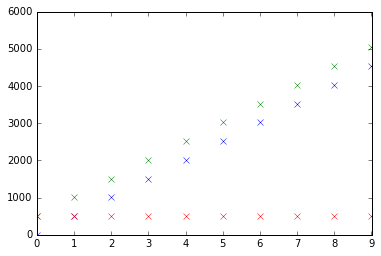

In [14]:
first = f["/INDEX/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/first"]
plt.plot(first, "x")
last = f["/INDEX/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/last"]
plt.plot(last, "x")
plt.plot(last.value-first.value, "x")

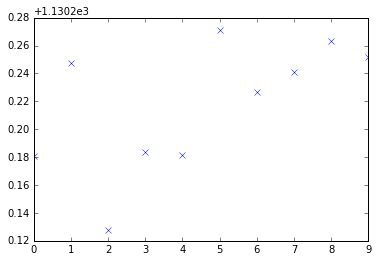

In [16]:
means = np.zeros(len(first))
for i in range(first.shape[0]):
    tf = first[i]
    tl = last[i]
    means[i] = np.mean(f["INSTRUMENT/DETLAB_LAB_DAQ-0/DET/0:xtdf/image/data"][tf:tl])
plt.plot(means, "x")